# Preproject routine 

In [7]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

import utility

sys.path.insert(1, module_path + '/src/models/')
import helper


import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
from scipy.stats import skew 


sys.path.insert(1, '/home/andrine/Desktop/tqwt_tools')
from tqwt_tools import DualQDecomposition
from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.signal import stft
from scipy.stats import skew, kurtosis
from PyEMD import EEMD
from sklearn.cross_decomposition import PLSRegression

from time import time
import sys
import os
figure_path = module_path + '/figures/small_segment_dataset_plots/'

sys.path.insert(1, module_path + '/src/')

from matplotlib.font_manager import FontProperties
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)
colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
colors_opa = ['#F9414466', '#90BE6D66', '#57759066','#F3722C66', '#F8961E66',
              '#F9844A66', '#F9C74F66', '#43AA8B66', '#4D908E66', '#277DA166']

sns.set_palette(sns.color_palette(colors))



def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 8000

import os
names = []
#files_path = '/home/andrine/Desktop/dataTromso/Hasse413/'
#files_path = '/home/andrine/Desktop/dataTromsoFiltered/allFilteres/'

files_path = module_path + '/data/minimal_dataset/data/'
info = pd.read_csv(module_path + '/data/minimal_dataset/info.csv')

Defining some helping functions, that will be important when extracting 

In [8]:
def get_features(data, sr):
    sr = sr
    n_mfcc = 30
    ft1 = librosa.feature.mfcc(data, sr = sr, n_mfcc=n_mfcc)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(data) , np.std(data), skew(data), np.max(data), np.median(data), np.min(data), utility.get_energy(data), utility.get_entropy(data)))

    ### MFCC features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))

    ### Spectral Features 
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    return np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))


Obtaining the data correlated with filepath, label and ID

Cutting the dataset down to 3 classes, and balancing the dataset

In [9]:
info['label'].value_counts()

wheeze     704
crackle    582
normal     554
Name: label, dtype: int64

In [10]:
indices = np.concatenate([np.where(info['label'] == 'normal')[0],
                          np.where(info['label'] == 'wheeze')[0][:580],
                          np.where(info['label'] == 'crackle')[0]])

'''indices = np.concatenate([np.where(info['label'] == 'wheeze')[0][:580],
                          np.where(info['label'] == 'crackle')[0]])'''


info = info.iloc[indices]

### Making unbiased train, test, val splits 

In [11]:
from sklearn.model_selection import train_test_split

info.sort_values(by=['patient_id'], inplace=True)


id_unique = info['patient_id'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_unique, test_size=0.25, random_state=42)

def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['patient_id'] == i)[0]
        indices = np.append([list(idx)] , [indices])
        
    return indices


indices_train = get_indices(id_train, info).astype(int)
indices_test = get_indices(id_test, info).astype(int)
indices_val = get_indices(id_val, info).astype(int)

print(info.iloc[indices_train]['label'].value_counts())

crackle    438
wheeze     431
normal     418
Name: label, dtype: int64


In [12]:
def get_data_array(data):
    error_in_data = {}
    count = 0
    
    X = []
    y = []
    for row in data.iterrows():
        audio_file = row[1]['filepath_new']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, 8000)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            #audio = znorm(audio)
            features = get_features(audio, sr)
            #features = get_emd_features(audio, sr, 5)
  
            X.append(features)
            y.append(label)
            
            count = count + 1
            print(f'Features extracted from : {count} of {len(data)}')

        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
    return (np.array(X), pd.Series(y))


indices = {
    'train' : indices_train,
    'test' : indices_test,
    'val' : indices_val
    
}

result_datasets = {
    'train' : ([], []),
    'test' : ([], []),
    'val' : ([], [])
    
}
start = time()

for name, i in indices.items():
    result_datasets[name] = get_data_array(info.iloc[i])

X_train, y_train = result_datasets['train']
X_test, y_test = result_datasets['test']
X_val, y_val = result_datasets['val']

print(f'Time: {time() - start}')

Features extracted from : 1 of 1287
Features extracted from : 2 of 1287
Features extracted from : 3 of 1287
Features extracted from : 4 of 1287
Features extracted from : 5 of 1287
Features extracted from : 6 of 1287
Features extracted from : 7 of 1287
Features extracted from : 8 of 1287
Features extracted from : 9 of 1287
Features extracted from : 10 of 1287
Features extracted from : 11 of 1287
Features extracted from : 12 of 1287
Features extracted from : 13 of 1287
Features extracted from : 14 of 1287
Features extracted from : 15 of 1287
Features extracted from : 16 of 1287
Features extracted from : 17 of 1287
Features extracted from : 18 of 1287
Features extracted from : 19 of 1287
Features extracted from : 20 of 1287
Features extracted from : 21 of 1287
Features extracted from : 22 of 1287
Features extracted from : 23 of 1287
Features extracted from : 24 of 1287
Features extracted from : 25 of 1287
Features extracted from : 26 of 1287
Features extracted from : 27 of 1287
Features e

Features extracted from : 237 of 1287
Features extracted from : 238 of 1287
Features extracted from : 239 of 1287
Features extracted from : 240 of 1287
Features extracted from : 241 of 1287
Features extracted from : 242 of 1287
Features extracted from : 243 of 1287
Features extracted from : 244 of 1287
Features extracted from : 245 of 1287
Features extracted from : 246 of 1287
Features extracted from : 247 of 1287
Features extracted from : 248 of 1287
Features extracted from : 249 of 1287
Features extracted from : 250 of 1287
Features extracted from : 251 of 1287
Features extracted from : 252 of 1287
Features extracted from : 253 of 1287
Features extracted from : 254 of 1287
Features extracted from : 255 of 1287
Features extracted from : 256 of 1287
Features extracted from : 257 of 1287
Features extracted from : 258 of 1287
Features extracted from : 259 of 1287
Features extracted from : 260 of 1287
Features extracted from : 261 of 1287
Features extracted from : 262 of 1287
Features ext

Features extracted from : 464 of 1287
Features extracted from : 465 of 1287
Features extracted from : 466 of 1287
Features extracted from : 467 of 1287
Features extracted from : 468 of 1287
Features extracted from : 469 of 1287
Features extracted from : 470 of 1287
Features extracted from : 471 of 1287
Features extracted from : 472 of 1287
Features extracted from : 473 of 1287
Features extracted from : 474 of 1287
Features extracted from : 475 of 1287
Features extracted from : 476 of 1287
Features extracted from : 477 of 1287
Features extracted from : 478 of 1287
Features extracted from : 479 of 1287
Features extracted from : 480 of 1287
Features extracted from : 481 of 1287
Features extracted from : 482 of 1287
Features extracted from : 483 of 1287
Features extracted from : 484 of 1287
Features extracted from : 485 of 1287
Features extracted from : 486 of 1287
Features extracted from : 487 of 1287
Features extracted from : 488 of 1287
Features extracted from : 489 of 1287
Features ext

Features extracted from : 690 of 1287
Features extracted from : 691 of 1287
Features extracted from : 692 of 1287
Features extracted from : 693 of 1287
Features extracted from : 694 of 1287
Features extracted from : 695 of 1287
Features extracted from : 696 of 1287
Features extracted from : 697 of 1287
Features extracted from : 698 of 1287
Features extracted from : 699 of 1287
Features extracted from : 700 of 1287
Features extracted from : 701 of 1287
Features extracted from : 702 of 1287
Features extracted from : 703 of 1287
Features extracted from : 704 of 1287
Features extracted from : 705 of 1287
Features extracted from : 706 of 1287
Features extracted from : 707 of 1287
Features extracted from : 708 of 1287
Features extracted from : 709 of 1287
Features extracted from : 710 of 1287
Features extracted from : 711 of 1287
Features extracted from : 712 of 1287
Features extracted from : 713 of 1287
Features extracted from : 714 of 1287
Features extracted from : 715 of 1287
Features ext

Features extracted from : 906 of 1287
Features extracted from : 907 of 1287
Features extracted from : 908 of 1287
Features extracted from : 909 of 1287
Features extracted from : 910 of 1287
Features extracted from : 911 of 1287
Features extracted from : 912 of 1287
Features extracted from : 913 of 1287
Features extracted from : 914 of 1287
Features extracted from : 915 of 1287
Features extracted from : 916 of 1287
Features extracted from : 917 of 1287
Features extracted from : 918 of 1287
Features extracted from : 919 of 1287
Features extracted from : 920 of 1287
Features extracted from : 921 of 1287
Features extracted from : 922 of 1287
Features extracted from : 923 of 1287
Features extracted from : 924 of 1287
Features extracted from : 925 of 1287
Features extracted from : 926 of 1287
Features extracted from : 927 of 1287
Features extracted from : 928 of 1287
Features extracted from : 929 of 1287
Features extracted from : 930 of 1287
Features extracted from : 931 of 1287
Features ext

Features extracted from : 1135 of 1287
Features extracted from : 1136 of 1287
Features extracted from : 1137 of 1287
Features extracted from : 1138 of 1287
Features extracted from : 1139 of 1287
Features extracted from : 1140 of 1287
Features extracted from : 1141 of 1287
Features extracted from : 1142 of 1287
Features extracted from : 1143 of 1287
Features extracted from : 1144 of 1287
Features extracted from : 1145 of 1287
Features extracted from : 1146 of 1287
Features extracted from : 1147 of 1287
Features extracted from : 1148 of 1287
Features extracted from : 1149 of 1287
Features extracted from : 1150 of 1287
Features extracted from : 1151 of 1287
Features extracted from : 1152 of 1287
Features extracted from : 1153 of 1287
Features extracted from : 1154 of 1287
Features extracted from : 1155 of 1287
Features extracted from : 1156 of 1287
Features extracted from : 1157 of 1287
Features extracted from : 1158 of 1287
Features extracted from : 1159 of 1287
Features extracted from :

Features extracted from : 77 of 344
Features extracted from : 78 of 344
Features extracted from : 79 of 344
Features extracted from : 80 of 344
Features extracted from : 81 of 344
Features extracted from : 82 of 344
Features extracted from : 83 of 344
Features extracted from : 84 of 344
Features extracted from : 85 of 344
Features extracted from : 86 of 344
Features extracted from : 87 of 344
Features extracted from : 88 of 344
Features extracted from : 89 of 344
Features extracted from : 90 of 344
Features extracted from : 91 of 344
Features extracted from : 92 of 344
Features extracted from : 93 of 344
Features extracted from : 94 of 344
Features extracted from : 95 of 344
Features extracted from : 96 of 344
Features extracted from : 97 of 344
Features extracted from : 98 of 344
Features extracted from : 99 of 344
Features extracted from : 100 of 344
Features extracted from : 101 of 344
Features extracted from : 102 of 344
Features extracted from : 103 of 344
Features extracted from 

Features extracted from : 309 of 344
Features extracted from : 310 of 344
Features extracted from : 311 of 344
Features extracted from : 312 of 344
Features extracted from : 313 of 344
Features extracted from : 314 of 344
Features extracted from : 315 of 344
Features extracted from : 316 of 344
Features extracted from : 317 of 344
Features extracted from : 318 of 344
Features extracted from : 319 of 344
Features extracted from : 320 of 344
Features extracted from : 321 of 344
Features extracted from : 322 of 344
Features extracted from : 323 of 344
Features extracted from : 324 of 344
Features extracted from : 325 of 344
Features extracted from : 326 of 344
Features extracted from : 327 of 344
Features extracted from : 328 of 344
Features extracted from : 329 of 344
Features extracted from : 330 of 344
Features extracted from : 331 of 344
Features extracted from : 332 of 344
Features extracted from : 333 of 344
Features extracted from : 334 of 344
Features extracted from : 335 of 344
F

Features extracted from : 195 of 429
Features extracted from : 196 of 429
Features extracted from : 197 of 429
Features extracted from : 198 of 429
Features extracted from : 199 of 429
Features extracted from : 200 of 429
Features extracted from : 201 of 429
Features extracted from : 202 of 429
Features extracted from : 203 of 429
Features extracted from : 204 of 429
Features extracted from : 205 of 429
Features extracted from : 206 of 429
Features extracted from : 207 of 429
Features extracted from : 208 of 429
Features extracted from : 209 of 429
Features extracted from : 210 of 429
Features extracted from : 211 of 429
Features extracted from : 212 of 429
Features extracted from : 213 of 429
Features extracted from : 214 of 429
Features extracted from : 215 of 429
Features extracted from : 216 of 429
Features extracted from : 217 of 429
Features extracted from : 218 of 429
Features extracted from : 219 of 429
Features extracted from : 220 of 429
Features extracted from : 221 of 429
F

Features extracted from : 420 of 429
Features extracted from : 421 of 429
Features extracted from : 422 of 429
Features extracted from : 423 of 429
Features extracted from : 424 of 429
Features extracted from : 425 of 429
Features extracted from : 426 of 429
Features extracted from : 427 of 429
Features extracted from : 428 of 429
Features extracted from : 429 of 429
Time: 18.407541751861572


In [10]:
file_splits = {
    '/features/extracted_ts_files/minimal_dataset_2class__preproject_TRAIN.ts' : (X_train, y_train),
    '/features/extracted_ts_files/minimal_dataset_2class__preproject_TEST.ts' : (X_test, y_test),
    '/features/extracted_ts_files/minimal_dataset_2class__preproject_VAL.ts' : (X_val, y_val)
}


def write_feature_extracted_dataset_to_ts(filename, X,y):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName Minimal UiT Lung Sound \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true crackle wheeze \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    for idx, row in enumerate(X):
        label = y[idx]

        try:
            new_row = str(list(row))[1:-1].replace(' ', '') + ':' + label + '\n'
            w.write(new_row)


        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
             
for name, i in file_splits.items():
    write_feature_extracted_dataset_to_ts(name, i[0], i[1])

# Testing classification 

In [46]:
from sktime.utils.data_processing import from_nested_to_2d_array
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn import preprocessing


X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preproject_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preproject_TEST.ts')
X_val, y_val = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preproject_VAL.ts')


X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)
X_val = from_nested_to_2d_array(X_val)

              precision    recall  f1-score   support

     crackle       0.56      0.60      0.58       111
      normal       0.45      0.34      0.39       105
      wheeze       0.56      0.62      0.59       128

    accuracy                           0.53       344
   macro avg       0.52      0.52      0.52       344
weighted avg       0.52      0.53      0.52       344



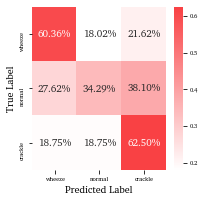

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


selector = SelectKBest(mutual_info_regression, k =30)
le  = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_ = le.transform(y_train)
selector.fit(X_train, y_train_)
X_train = selector.transform(X_train)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)

class_names =  list(pd.factorize(y_train)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)

#clf = SVC(C=100, gamma=0.1)

clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test, y_pred, module_path = module_path, class_names = class_names, color_index = 0)

f.savefig(figure_path + f'cm_preproject_3class_rf.pdf', bbox_inches='tight')

print(classification_report(y_test, y_pred))

In [47]:
from sktime.utils.data_processing import from_nested_to_2d_array

X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preproject_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preproject_TEST.ts')
X_val, y_val = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preproject_VAL.ts')


X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)
X_val = from_nested_to_2d_array(X_val)

              precision    recall  f1-score   support

     crackle       0.77      0.83      0.80       123
      wheeze       0.80      0.74      0.77       114

    accuracy                           0.78       237
   macro avg       0.79      0.78      0.78       237
weighted avg       0.79      0.78      0.78       237



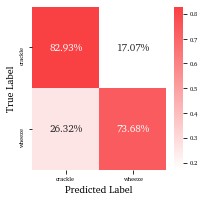

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


selector = SelectKBest(mutual_info_regression, k =30)
le  = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_ = le.transform(y_train)
selector.fit(X_train, y_train_)
X_train = selector.transform(X_train)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)

class_names =  list(pd.factorize(y_train)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)

#clf = SVC(C=100, gamma=0.1)

clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test, y_pred, module_path = module_path, class_names = class_names, color_index = 0)

f.savefig(figure_path + f'cm_preproject_2class_rf.pdf', bbox_inches='tight')

print(classification_report(y_test, y_pred))

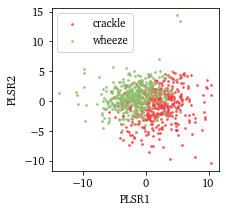

In [30]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_ = le.transform(y_train)

pls2 = PLSRegression(n_components=2)
p2 = pls2.fit_transform(X_train, y_train_)
f, ax = helper.scatterplot_with_colors(p2[0], y_train_,
                                       module_path, new_legends = le.classes_,
                                       x_y_labels = ['PLSR1', 'PLSR2'])

plt.show()

f.savefig(figure_path + f'PLSR_preproject_2class.pdf', bbox_inches='tight')